In [27]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.8,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

tf.compat.v1.disable_eager_execution()

순환 신경망의 성능과 일반화 능력을 향상시키기 위한 3가지 고급 기술을 살펴보겠습니다.
* **순환 드랍아웃 (Recurrent Dropout)**: 순환 층에서 과대적합을 방지하기 위해 드롭아웃을 사용
* **스태킹 순환 층 (Stacking Recurrent Layer)**: 네트워크의 표현 능력 (representation power)을 증가시킴
* **양방향 순환 층 (Bidirectional Recurrent Layer)**: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킴

### 기온 예측 문제

`예나`시의 온도 예측 문제를 시연해보겠습니다.
* 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다
* 이 데이터를 사용하여 마지막 데이터 포인트에서 24시간 이후의 온도를 예측하겠습니다
* 데이터셋에는 수년간 걸쳐 14개의 관측치가 10분마다 기록되어있습니다.
* 원본에는 2003년부터 기록되어 있지만 이 예제에서는 2009 ~ 2016년 사이의 데이터만 사용합니다

```bash
cd ./data/
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.zip
```

##### 예나의 날씨 데이터 조사하기

In [5]:
import os

data_dir = "./data/jena_climate/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


출력된 줄 수는 42만 451입니다.

##### 데이터 파싱

In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

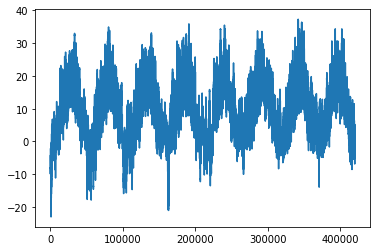

In [7]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] ## 온도 (섭씨)
plt.plot(range(len(temp)), temp)

다음은 기간을 좁혀서 처음 10일간 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다

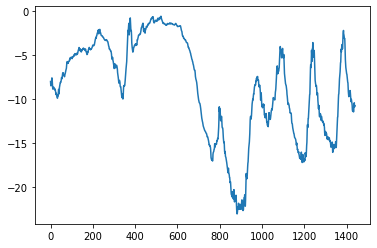

In [8]:
plt.plot(range(1440), temp[:1440])

### 데이터 준비

이 문제의 정확한 정의는 다음과 같습니다
* lookback 타임스텝 (하나의 타임스텝은 10분) 만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다
* 데이터를 바탕으로 delay 타임스텝 이후의 온도를 에측할 수 있을까요?
* 변수는 아래와 같습니다
    * `lookback = 1440`: 10일전 데이터로 돌아갑니다
    * `steps = 6`: 1시간마다 데이터 포인트 하나를 샘플링합니다
    * `delay = 144`: 24시간이 지난 데이터가 타깃이 됩니다
    
시작하기 전에 두가지 작업을 처리해야합니다
* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다.
    * 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다. 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꿉니다
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다.
    * 데이터셋에 있는 샘플은 중복이 많습니다. 샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다
    * 모든 샘플이 각기 메모리에 적재하는 것은 낭비가 심하므로 원본 데이터를 사용하여 그때그때 배치합니다

##### 데이터 정규화하기

In [9]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

다음은 제너레이터를 생성할 것입니다. 
* (samples, targets) 튜플을 반복적으로 반환합니다.
* samples는 입력 데이터로 사용한 배치
* targets은 이에 대응하는 온도의 배열
* `data`: 원본 배열
* `lookback`: 입력으로 사용하기 위해 거슬러 올라갈 타임스탭
* `delay`: 타깃으로 사용할 미래의 타임스텝
* `min_index`, `max_index`: 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스
* `shuffle`: 샘플을 섞을지, 시간 순서대로 추출할지를 결정
* `batch_size`: 배치의 샘플 수
* `step`: 데이터를 샘플링할 타임스텝 간격

##### 시계열 데이터와 타깃을 반환하는 제너레이터 함수

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

이 제너레이터 함수를 이용하여 훈련용, 검증용, 테스트용으로 3개의 제너레이터를 만들어보겠습니다. 각 제너레이터는 원본 데이터에서 다른 시간대로 사용합니다.

##### 훈련, 검증, 테스트 제너레이터 준비하기

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)
test_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 상식 수준의 기준점

블랙 박스같은 딥러닝 모델을 사용하여 온도 예측 문제를 풀기전 같단한 상식 수준의 해법을 시도해보겠습니다. 이는 정상 여부를 확인하기 위한 용도이며 고성능 모델이라면 넘어야할 기준점을 넘깁니다.
* 불균형한 분류 문제: 클래스 A의 샘플이 90%, B의 샘플이 10%라면 상식 수준의 접근법은 샘플을 항상 A로 예측하는 것입니다. 그러면 분류기는 전반적으로 90%의 정확도를 보여줍니다.
* 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다. 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것입니다.
* 이를 평균 절댓값 오차로 평가해보겠습니다
    * `np.mean(np.abs(preds - targets))`

##### 상식적인 기준 모델의 MAE 계산하기

In [12]:
def evaluate_naive_method():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28872579267840803


출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와닿지는 않습니다. 평균 절대값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57도가 됩니다.

##### MAE를 섭씨 단위로 변환하기

In [14]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

### 기본적인 머신 러닝 방법

상식 수준의 기준점을 세워두었습니다. RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손 쉽게 만들수있는 머신 러닝 모델을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 됩니다.

먼저 데이터를 펼쳐서 2개의 Dense 층을 통과시키는 완전 연결 네트워크를 훈련시킵니다
* 회귀 문제이므로 지막 Dense층에 활성화 함수를 두지 않았습니다.

##### 완전 연결 모델을 훈련하고 평가하기

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20
496/500 [============================>.] - ETA: 0s - batch: 247.5000 - size: 128.0000 - loss: 0.8959

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 7s 13ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.8926 - val_loss: 0.5506
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.3534 - val_loss: 0.3195
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.2827 - val_loss: 0.2989
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.2616 - val_loss: 0.3046
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.2496 - val_loss: 0.3146
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.2413 - val_loss: 0.3137
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - batch: 249.5000 - size: 128.0000 - loss: 0.2353 - val_loss: 0.3107
Epoch 8/20
500/500 [==============================] - 6s 12

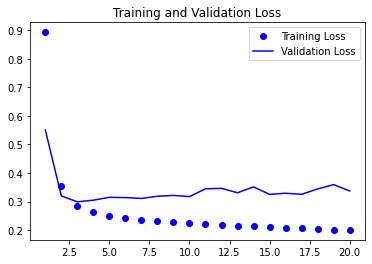

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

일부 검증 손실은 학습을 사용하지 않은 기준점 (0.29)에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다.

### 첫번째 순환 신경망

첫번째 완전 연결 네트워크는 잘 작동하지 않았습니다.
* 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다

이런 시퀀스 데이터에 잘 들어맞는 순환 시퀀스 처리 모델로 다시 시도해보겠습니다
* **Gated Recurrent Unit (GRU)** 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 계산 비용이 덜 듭니다
* 하지만 LSTM만큼 표현 학습 능력이 뛰어나지는 않습니다
* 계산 비용과 학습 능력 사이의 Tradeoff는 머신 러닝 어디에나 등장합니다

##### GRU를 사용한 모델 훈련하기

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     recurrent_activation = 'sigmoid',
                     reset_after = True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
 41/500 [=>............................] - ETA: 34s - batch: 20.0000 - size: 128.0000 - loss: 0.3710

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()